In [10]:
import torch
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch.nn as nn
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

In [3]:
class PR_CNN(nn.Module):
    def __init__(self, **kwargs):
        super(PR_CNN, self).__init__()
        self.expected_input_size = kwargs.get('input_dim', None)

        # First layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=kwargs.get('input_channels', None),
                      out_channels=kwargs.get('input_channels', None)*5,
                      kernel_size=3,
                      stride=3),
            nn.LeakyReLU()
        )
        # Second layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=kwargs.get('input_channels', None)*5,
                      out_channels=kwargs.get('input_channels', None)*25,
                      kernel_size=3,
                      stride=3),
            nn.LeakyReLU()
        )
        # Third layer
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=kwargs.get('input_channels', None)*25,
                      out_channels=1536,
                      kernel_size=3,
                      stride=3),
            nn.LeakyReLU()
        )
        

        # Classification layer
        self.fc = nn.Sequential(
            Flatten(),
            nn.Linear(1536, kwargs.get('output_channels', None))
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

In [4]:
import numpy as np
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def train(model, train_loader, optimizer, loss_fn, print_every=100):
    '''
    Trains the model for one epoch
    '''
    model.train()
    losses = []
    n_correct = 0
    for iteration, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        optimizer.zero_grad()
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        n_correct += torch.sum(output.argmax(1) == labels).item()
    accuracy = 100.0 * n_correct / len(train_loader.dataset)
    return np.mean(np.array(losses)), accuracy
            
def test(model, test_loader, loss_fn):
    '''
    Tests the model on data from test_loader
    '''
    model.eval()
    test_loss = 0
    n_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = loss_fn(output, labels)
            test_loss += loss.item()
            n_correct += torch.sum(output.argmax(1) == labels).item()

    average_loss = test_loss / len(test_loader)
    accuracy = 100.0 * n_correct / len(test_loader.dataset)
    return average_loss, accuracy

def fit(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs, scheduler=None):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
        val_loss, val_accuracy = test(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        if scheduler:
            scheduler.step() # argument only needed for ReduceLROnPlateau
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                          train_losses[-1],
                                                                                                          train_accuracies[-1],
                                                                                                          val_losses[-1],
                                                                                                          val_accuracies[-1]))
    
    return val_accuracies

In [5]:
transform_dataset = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

In [6]:
train_dataset = datasets.ImageFolder('mnist/train',transform=transform_dataset)

In [7]:
val_dataset = datasets.ImageFolder('mnist/val',transform=transform_dataset)

In [8]:
test_dataset = datasets.ImageFolder('mnist/test',transform=transform_dataset)

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=100, shuffle=True)

Epoch 1/25: train_loss: 0.3301, train_accuracy: 90.0473, val_loss: 0.1624, val_accuracy: 95.1515
Epoch 2/25: train_loss: 0.0998, train_accuracy: 96.9104, val_loss: 0.1023, val_accuracy: 96.8333
Epoch 3/25: train_loss: 0.0661, train_accuracy: 97.8781, val_loss: 0.0841, val_accuracy: 97.4545
Epoch 4/25: train_loss: 0.0438, train_accuracy: 98.6269, val_loss: 0.0831, val_accuracy: 97.6869
Epoch 5/25: train_loss: 0.0321, train_accuracy: 98.9229, val_loss: 0.0921, val_accuracy: 97.4343
Epoch 6/25: train_loss: 0.0253, train_accuracy: 99.1617, val_loss: 0.0768, val_accuracy: 97.7424
Epoch 7/25: train_loss: 0.0190, train_accuracy: 99.3756, val_loss: 0.0789, val_accuracy: 97.8737
Epoch 8/25: train_loss: 0.0166, train_accuracy: 99.4876, val_loss: 0.1016, val_accuracy: 97.6717
Epoch 9/25: train_loss: 0.0126, train_accuracy: 99.6070, val_loss: 0.0798, val_accuracy: 98.0152
Epoch 10/25: train_loss: 0.0114, train_accuracy: 99.6095, val_loss: 0.0981, val_accuracy: 97.6515
Epoch 11/25: train_loss: 0.01

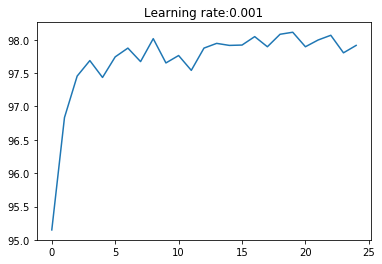

Epoch 1/25: train_loss: 0.2794, train_accuracy: 91.1915, val_loss: 0.1294, val_accuracy: 96.0253
Epoch 2/25: train_loss: 0.0878, train_accuracy: 97.2811, val_loss: 0.1012, val_accuracy: 96.8434
Epoch 3/25: train_loss: 0.0566, train_accuracy: 98.2338, val_loss: 0.0827, val_accuracy: 97.5101
Epoch 4/25: train_loss: 0.0430, train_accuracy: 98.5274, val_loss: 0.0869, val_accuracy: 97.5707
Epoch 5/25: train_loss: 0.0313, train_accuracy: 98.9428, val_loss: 0.1102, val_accuracy: 97.1263
Epoch 6/25: train_loss: 0.0293, train_accuracy: 98.9851, val_loss: 0.0909, val_accuracy: 97.8030
Epoch 7/25: train_loss: 0.0242, train_accuracy: 99.1766, val_loss: 0.0952, val_accuracy: 97.6515
Epoch 8/25: train_loss: 0.0187, train_accuracy: 99.3781, val_loss: 0.1207, val_accuracy: 97.4444
Epoch 9/25: train_loss: 0.0227, train_accuracy: 99.2960, val_loss: 0.1203, val_accuracy: 97.5455
Epoch 10/25: train_loss: 0.0199, train_accuracy: 99.4129, val_loss: 0.1124, val_accuracy: 97.7727
Epoch 11/25: train_loss: 0.01

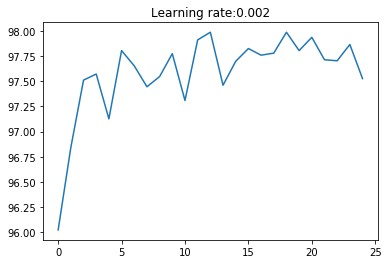

Epoch 1/25: train_loss: 0.2571, train_accuracy: 91.8955, val_loss: 0.1153, val_accuracy: 96.4495
Epoch 2/25: train_loss: 0.0871, train_accuracy: 97.3284, val_loss: 0.0886, val_accuracy: 97.2020
Epoch 3/25: train_loss: 0.0610, train_accuracy: 98.0100, val_loss: 0.0816, val_accuracy: 97.6212
Epoch 4/25: train_loss: 0.0445, train_accuracy: 98.5348, val_loss: 0.1209, val_accuracy: 96.8636
Epoch 5/25: train_loss: 0.0389, train_accuracy: 98.7562, val_loss: 0.0983, val_accuracy: 97.4949
Epoch 6/25: train_loss: 0.0369, train_accuracy: 98.8184, val_loss: 0.1092, val_accuracy: 97.2626
Epoch 7/25: train_loss: 0.0343, train_accuracy: 98.9627, val_loss: 0.1298, val_accuracy: 97.2980
Epoch 8/25: train_loss: 0.0317, train_accuracy: 99.0572, val_loss: 0.1197, val_accuracy: 97.5404
Epoch 9/25: train_loss: 0.0261, train_accuracy: 99.3134, val_loss: 0.1060, val_accuracy: 97.9141
Epoch 10/25: train_loss: 0.0176, train_accuracy: 99.4950, val_loss: 0.1493, val_accuracy: 97.4293
Epoch 11/25: train_loss: 0.03

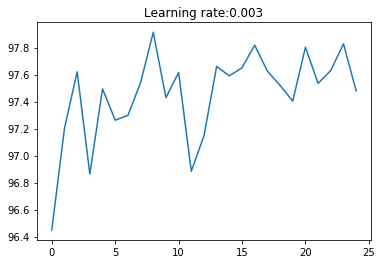

Epoch 1/25: train_loss: 0.2616, train_accuracy: 91.9428, val_loss: 0.1190, val_accuracy: 96.3283
Epoch 2/25: train_loss: 0.0906, train_accuracy: 97.1144, val_loss: 0.0968, val_accuracy: 96.9899
Epoch 3/25: train_loss: 0.0630, train_accuracy: 98.0124, val_loss: 0.1243, val_accuracy: 96.6616
Epoch 4/25: train_loss: 0.0578, train_accuracy: 98.2065, val_loss: 0.1031, val_accuracy: 97.3283
Epoch 5/25: train_loss: 0.0463, train_accuracy: 98.5721, val_loss: 0.1317, val_accuracy: 97.0960
Epoch 6/25: train_loss: 0.0430, train_accuracy: 98.7015, val_loss: 0.1265, val_accuracy: 97.2778
Epoch 7/25: train_loss: 0.0441, train_accuracy: 98.7562, val_loss: 0.1764, val_accuracy: 96.7071
Epoch 8/25: train_loss: 0.0482, train_accuracy: 98.7836, val_loss: 0.1412, val_accuracy: 97.6010
Epoch 9/25: train_loss: 0.0384, train_accuracy: 98.9975, val_loss: 0.1614, val_accuracy: 97.3232
Epoch 10/25: train_loss: 0.0492, train_accuracy: 98.8433, val_loss: 0.1650, val_accuracy: 97.0960
Epoch 11/25: train_loss: 0.03

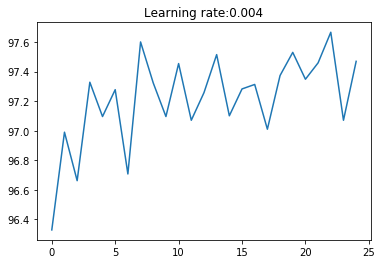

Epoch 1/25: train_loss: 0.3042, train_accuracy: 90.6965, val_loss: 0.1263, val_accuracy: 96.0505
Epoch 2/25: train_loss: 0.0975, train_accuracy: 96.9925, val_loss: 0.1222, val_accuracy: 96.4040
Epoch 3/25: train_loss: 0.0749, train_accuracy: 97.6766, val_loss: 0.1136, val_accuracy: 96.7071
Epoch 4/25: train_loss: 0.0643, train_accuracy: 98.0124, val_loss: 0.1222, val_accuracy: 96.8081
Epoch 5/25: train_loss: 0.0582, train_accuracy: 98.2711, val_loss: 0.1364, val_accuracy: 97.1263
Epoch 6/25: train_loss: 0.0722, train_accuracy: 97.9776, val_loss: 0.1228, val_accuracy: 97.0455
Epoch 7/25: train_loss: 0.0491, train_accuracy: 98.5323, val_loss: 0.1779, val_accuracy: 95.9192
Epoch 8/25: train_loss: 0.0570, train_accuracy: 98.5249, val_loss: 0.1656, val_accuracy: 97.2424
Epoch 9/25: train_loss: 0.0465, train_accuracy: 98.8259, val_loss: 0.1918, val_accuracy: 97.0354
Epoch 10/25: train_loss: 0.0532, train_accuracy: 98.7413, val_loss: 0.2067, val_accuracy: 96.9596
Epoch 11/25: train_loss: 0.05

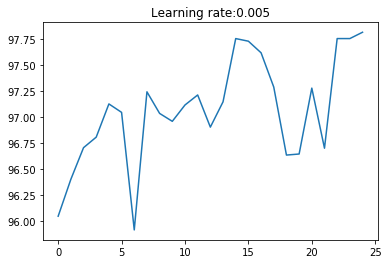

Epoch 1/25: train_loss: 0.2896, train_accuracy: 91.1368, val_loss: 0.1177, val_accuracy: 96.3586
Epoch 2/25: train_loss: 0.1060, train_accuracy: 96.7289, val_loss: 0.1300, val_accuracy: 96.6162
Epoch 3/25: train_loss: 0.0875, train_accuracy: 97.3333, val_loss: 0.1121, val_accuracy: 97.0505
Epoch 4/25: train_loss: 0.0803, train_accuracy: 97.6766, val_loss: 0.1750, val_accuracy: 95.9848
Epoch 5/25: train_loss: 0.0787, train_accuracy: 97.8358, val_loss: 0.1250, val_accuracy: 97.2020
Epoch 6/25: train_loss: 0.0717, train_accuracy: 98.0597, val_loss: 0.1786, val_accuracy: 96.2475
Epoch 7/25: train_loss: 0.0753, train_accuracy: 98.0522, val_loss: 0.1698, val_accuracy: 96.4343
Epoch 8/25: train_loss: 0.0575, train_accuracy: 98.4975, val_loss: 0.1459, val_accuracy: 97.1818
Epoch 9/25: train_loss: 0.0677, train_accuracy: 98.4701, val_loss: 0.2134, val_accuracy: 96.3788
Epoch 10/25: train_loss: 0.0878, train_accuracy: 98.1095, val_loss: 0.2421, val_accuracy: 96.7323
Epoch 11/25: train_loss: 0.07

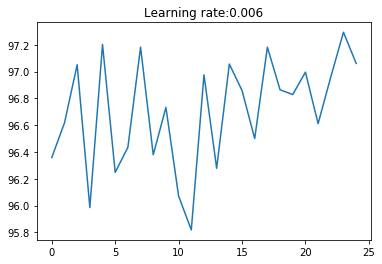

Epoch 1/25: train_loss: 0.2712, train_accuracy: 91.5572, val_loss: 0.1344, val_accuracy: 96.0051
Epoch 2/25: train_loss: 0.1217, train_accuracy: 96.2960, val_loss: 0.1202, val_accuracy: 96.6162
Epoch 3/25: train_loss: 0.0967, train_accuracy: 97.1219, val_loss: 0.1185, val_accuracy: 96.9495
Epoch 4/25: train_loss: 0.0932, train_accuracy: 97.4055, val_loss: 0.1414, val_accuracy: 96.5354
Epoch 5/25: train_loss: 0.0907, train_accuracy: 97.4900, val_loss: 0.1276, val_accuracy: 97.1162
Epoch 6/25: train_loss: 0.0833, train_accuracy: 97.8085, val_loss: 0.1940, val_accuracy: 96.0202
Epoch 7/25: train_loss: 0.0974, train_accuracy: 97.5796, val_loss: 0.2260, val_accuracy: 95.6263
Epoch 8/25: train_loss: 0.0858, train_accuracy: 97.9502, val_loss: 0.1987, val_accuracy: 96.7323
Epoch 9/25: train_loss: 0.0961, train_accuracy: 98.0199, val_loss: 0.2093, val_accuracy: 96.5253
Epoch 10/25: train_loss: 0.0844, train_accuracy: 98.2363, val_loss: 0.3147, val_accuracy: 96.2071
Epoch 11/25: train_loss: 0.16

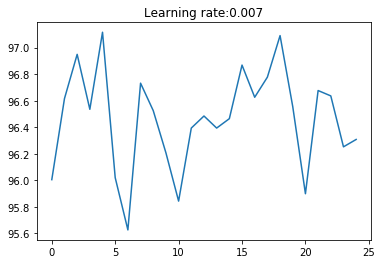

Epoch 1/25: train_loss: 0.2741, train_accuracy: 91.5920, val_loss: 0.1280, val_accuracy: 96.2475
Epoch 2/25: train_loss: 0.1178, train_accuracy: 96.4378, val_loss: 0.2081, val_accuracy: 94.1162
Epoch 3/25: train_loss: 0.1028, train_accuracy: 96.9627, val_loss: 0.1228, val_accuracy: 96.7475
Epoch 4/25: train_loss: 0.1101, train_accuracy: 97.0473, val_loss: 0.1499, val_accuracy: 96.1616
Epoch 5/25: train_loss: 0.1026, train_accuracy: 97.3458, val_loss: 0.1871, val_accuracy: 96.1010
Epoch 6/25: train_loss: 0.1367, train_accuracy: 96.9204, val_loss: 0.2328, val_accuracy: 96.0707
Epoch 7/25: train_loss: 0.1370, train_accuracy: 97.0572, val_loss: 0.2281, val_accuracy: 95.9798
Epoch 8/25: train_loss: 0.1343, train_accuracy: 97.2910, val_loss: 0.2795, val_accuracy: 95.2626
Epoch 9/25: train_loss: 0.1150, train_accuracy: 97.7289, val_loss: 0.2496, val_accuracy: 96.5859
Epoch 10/25: train_loss: 0.1090, train_accuracy: 97.8856, val_loss: 0.3008, val_accuracy: 96.0253
Epoch 11/25: train_loss: 0.48

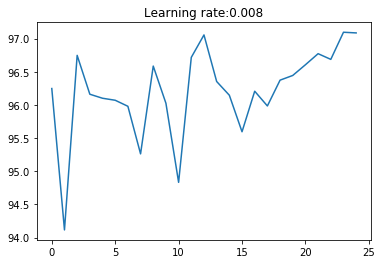

Epoch 1/25: train_loss: 0.2875, train_accuracy: 91.2413, val_loss: 0.1352, val_accuracy: 95.9444
Epoch 2/25: train_loss: 0.1282, train_accuracy: 96.1741, val_loss: 0.1482, val_accuracy: 95.7576
Epoch 3/25: train_loss: 0.1174, train_accuracy: 96.6667, val_loss: 0.1461, val_accuracy: 96.3434
Epoch 4/25: train_loss: 0.1220, train_accuracy: 96.7463, val_loss: 0.1739, val_accuracy: 96.2222
Epoch 5/25: train_loss: 0.1313, train_accuracy: 96.7836, val_loss: 0.2194, val_accuracy: 95.1313
Epoch 6/25: train_loss: 0.1511, train_accuracy: 96.5050, val_loss: 0.1971, val_accuracy: 95.6162
Epoch 7/25: train_loss: 0.4644, train_accuracy: 95.0622, val_loss: 0.3928, val_accuracy: 93.7626
Epoch 8/25: train_loss: 0.1479, train_accuracy: 96.7761, val_loss: 0.1924, val_accuracy: 96.3889
Epoch 9/25: train_loss: 0.0712, train_accuracy: 98.2264, val_loss: 0.2427, val_accuracy: 96.7424
Epoch 10/25: train_loss: 0.0893, train_accuracy: 98.0274, val_loss: 0.2574, val_accuracy: 96.1818
Epoch 11/25: train_loss: 0.12

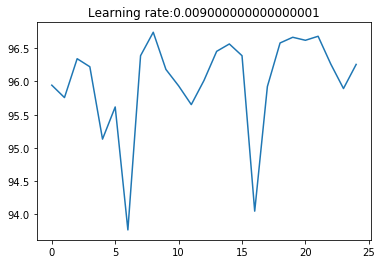

In [11]:
nb_epochs = 25
i = 0
for learning_rate in np.arange(0.001, 0.01, 0.001):
    pre_defined_kwargs = {'input_dim': (28,28), 'input_channels': 3, 'output_channels': 10}
    model_cnn = PR_CNN(**pre_defined_kwargs)
    model_cnn = model_cnn.to(device)
    optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    accuracies = fit(train_loader, val_loader, model_cnn, optimizer, loss_fn, nb_epochs)
    plt.title('Learning rate:' + str(learning_rate))
    plt.plot(accuracies)
    plt.savefig('cnn_plot/'+str(i) + '.png')
    plt.show() 
    i = i + 1